In [25]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [12]:
# Create helper function to load events from both sessions
def load_sub_events(base_path, sub):
    all_events = []
    for ses in ['ses-1', 'ses-2']:
        ses_path = os.path.join(base_path, sub, ses, 'func')
        if not os.path.exists(ses_path):
            print(f"Missing folder for {sub} {ses}")
            continue
        for file in os.listdir(ses_path):
            if file.endswith('_events.tsv'):
                df = pd.read_csv(os.path.join(ses_path, file), sep='\t')
                df['subject'] = sub
                df['session'] = ses
                df['run'] = file.split('_run-')[1].split('_')[0] if '_run-' in file else '1'
                all_events.append(df)
    if all_events:
        return pd.concat(all_events, ignore_index=True)
    else:
        return pd.DataFrame()

### Load and Inspect the Data

In [13]:
base_path = '../data/ds001907'
sub = 'sub-RC4101'
events_df = load_sub_events(base_path, sub)
print(f"Loaded {len(events_df)} trials for {sub}")
display(events_df.head())

Loaded 864 trials for sub-RC4101


,onset,duration,trial_type,trial_type_err,response_time,accuracy,target_dir,target_pos,correct_resp,resp,subject,session,run
0,25.810,0.2,NoCue,NoCue,NaN,NaN,NaN,NaN,NaN,NaN,sub-RC4101,ses-1,2
1,26.293,2.0,Congruent,Congruent,610.0,1.0,Left,Up,y,y,sub-RC4101,ses-1,2
2,41.302,0.2,SpatialCue,SpatialCue,NaN,NaN,NaN,Down,NaN,NaN,sub-RC4101,ses-1,2
3,42.551,2.0,Incongruent,Incongruent,641.0,1.0,Right,Down,g,g,sub-RC4101,ses-1,2
4,49.065,0.2,CenterCue,CenterCue,NaN,NaN,NaN,NaN,NaN,NaN,sub-RC4101,ses-1,2


### Perform some basic data checks

In [14]:
# Missing values
print("\nMissing values per column:")
print(events_df.isna().sum())

# Data types
print("\nData types:")
print(events_df.dtypes)

# Unique values for categorical columns
cat_cols = ['trial_type', 'trial_type_err', 'target_dir', 'target_pos', 'correct_resp', 'resp']
for col in cat_cols:
    if col in events_df.columns:
        print(f"\n{col}: {events_df[col].unique()}")


Missing values per column:
onset               0
duration            0
trial_type          0
trial_type_err      0
response_time     432
accuracy          432
target_dir        432
target_pos        288
correct_resp      432
resp              432
subject             0
session             0
run                 0
dtype: int64

Data types:
onset             float64
duration          float64
trial_type         object
trial_type_err     object
response_time     float64
accuracy          float64
target_dir         object
target_pos         object
correct_resp       object
resp               object
subject            object
session            object
run                object
dtype: object

trial_type: ['NoCue' 'Congruent' 'SpatialCue' 'Incongruent' 'CenterCue']

trial_type_err: ['NoCue' 'Congruent' 'SpatialCue' 'Incongruent' 'CenterCue' 'CueErr'
 'TargetErr']

target_dir: [nan 'Left' 'Right']

target_pos: [nan 'Up' 'Down']

correct_resp: [nan 'y' 'g']

resp: [nan 'y' 'g']


### Calculate some initial summary stats

In [16]:
print("\nResponse time summary (s):")
print(events_df['response_time'].describe())
print("\nAccuracy summary:")
print(events_df['accuracy'].value_counts(normalize=True) * 100)


Response time summary (s):
count     432.000000
mean      670.729167
std        99.729394
min       444.000000
25%       600.750000
50%       665.000000
75%       735.250000
max      1171.000000
Name: response_time, dtype: float64

Accuracy summary:
accuracy
1.0    97.685185
0.0     2.314815
Name: proportion, dtype: float64


### Let us plot some chart to get a summary of the behavioural data

                mean_rt      std_rt  acc_rate    n
trial_type                                        
Congruent    624.976852   75.556813  0.990741  216
Incongruent  716.481481  100.116489  0.962963  216


/var/folders/4p/rtytcsp11j70tn7dmwys7lrm0000gn/T/ipykernel_44102/2971795962.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=target_df, x='trial_type', y='response_time', palette='pastel')


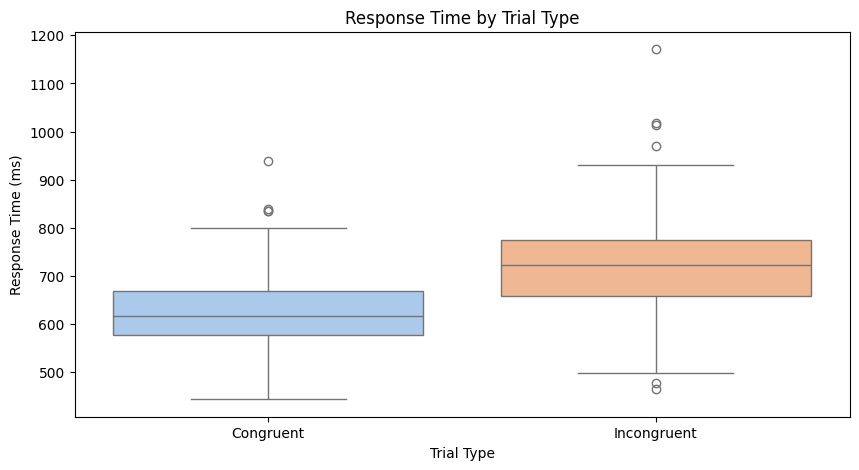

/var/folders/4p/rtytcsp11j70tn7dmwys7lrm0000gn/T/ipykernel_44102/2971795962.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=target_df, x='trial_type', y='accuracy', palette='pastel', ci=None)
/var/folders/4p/rtytcsp11j70tn7dmwys7lrm0000gn/T/ipykernel_44102/2971795962.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=target_df, x='trial_type', y='accuracy', palette='pastel', ci=None)


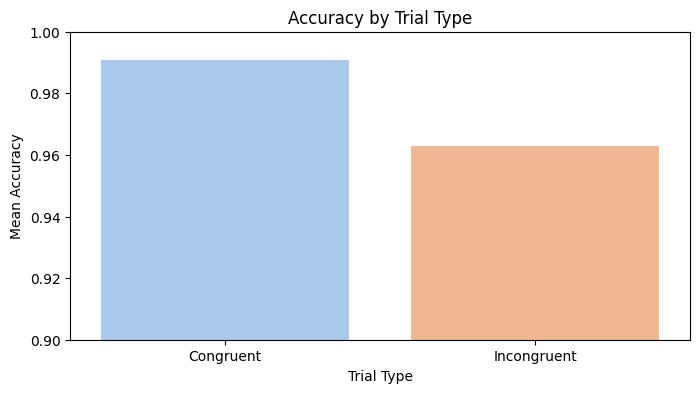

In [18]:
# Filter target trials (those with responses)
target_df = events_df.dropna(subset=['response_time']).copy()

# Basic summary by trial type
summary_by_trial = (
    target_df.groupby('trial_type')
    .agg(
        mean_rt=('response_time', 'mean'),
        std_rt=('response_time', 'std'),
        acc_rate=('accuracy', 'mean'),
        n=('response_time', 'count')
    )
    .sort_index()
)

print(summary_by_trial)

# --- Plots ---
plt.figure(figsize=(10, 5))
sns.boxplot(data=target_df, x='trial_type', y='response_time', palette='pastel')
plt.title('Response Time by Trial Type')
plt.xlabel('Trial Type')
plt.ylabel('Response Time (ms)')
plt.show()

plt.figure(figsize=(8, 4))
sns.barplot(data=target_df, x='trial_type', y='accuracy', palette='pastel', ci=None)
plt.title('Accuracy by Trial Type')
plt.xlabel('Trial Type')
plt.ylabel('Mean Accuracy')
plt.ylim(0.9, 1.0)
plt.show()

### Let us now link Cue to Target Trials

In [21]:
cue_types = ['SpatialCue', 'CenterCue', 'NoCue']

# Find valid target trials preceded by a cue
target_trials = events_df[
    (events_df['trial_type'].isin(['Congruent', 'Incongruent'])) &
    (events_df['prev_trial_type'].isin(cue_types))
].copy()

# New summary
cue_target_summary = (
    target_trials.groupby(['prev_trial_type', 'trial_type'])
    .agg(
        mean_rt=('response_time', 'mean'),
        std_rt=('response_time', 'std'),
        acc_rate=('accuracy', 'mean'),
        n=('response_time', 'count')
    )
    .sort_index()
)

print(cue_target_summary)


                                mean_rt      std_rt  acc_rate   n
prev_trial_type trial_type                                       
CenterCue       Congruent    626.000000   49.057789  1.000000   4
                Incongruent  729.428571  154.115603  0.714286   7
NoCue           Congruent    616.600000   82.895114  0.900000  10
                Incongruent  717.333333   56.500147  1.000000   6
SpatialCue      Congruent    677.500000   34.648232  1.000000   2
                Incongruent  719.571429   90.385945  1.000000   7


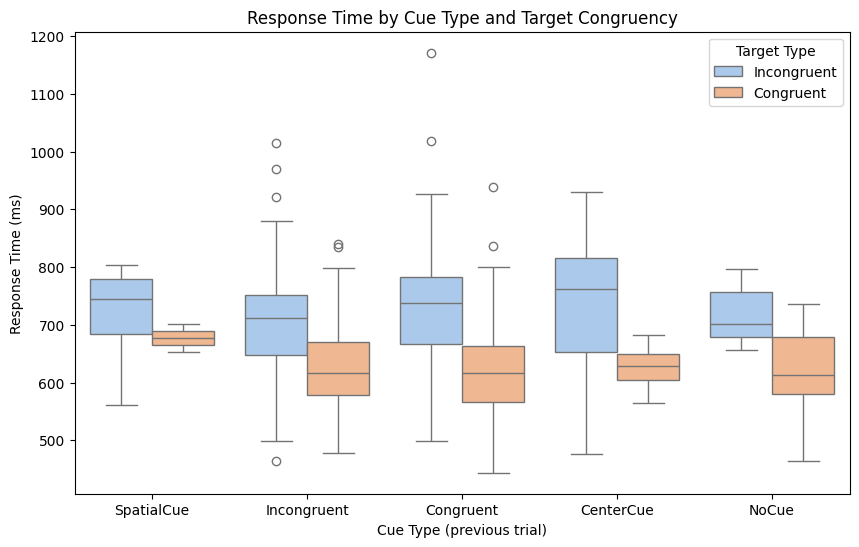

In [20]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=target_trials,
    x='prev_trial_type',
    y='response_time',
    hue='trial_type',
    palette='pastel'
)
plt.title('Response Time by Cue Type and Target Congruency')
plt.xlabel('Cue Type (previous trial)')
plt.ylabel('Response Time (ms)')
plt.legend(title='Target Type')
plt.show()


### Next is aggregating all of the subjects

In [23]:
base_path = "../data/ds001907"
cue_types = ['SpatialCue', 'CenterCue', 'NoCue']
target_types = ['Congruent', 'Incongruent']

def load_all_subjects(base_path):
    all_subjects = []
    subs = sorted([s for s in os.listdir(base_path) if s.startswith("sub-")])
    for sub in tqdm(subs):
        sub_events = []
        for ses in ["ses-1", "ses-2"]:
            ses_path = os.path.join(base_path, sub, ses, "func")
            if not os.path.exists(ses_path):
                continue
            for file in os.listdir(ses_path):
                if file.endswith("_events.tsv"):
                    df = pd.read_csv(os.path.join(ses_path, file), sep="\t")
                    df["subject"] = sub
                    df["session"] = ses
                    sub_events.append(df)
        if sub_events:
            df = pd.concat(sub_events, ignore_index=True).sort_values(by="onset").reset_index(drop=True)
            df["prev_trial_type"] = df["trial_type"].shift(1)
            
            # Keep only target trials preceded by cue
            df = df[
                df["trial_type"].isin(target_types) &
                df["prev_trial_type"].isin(cue_types)
            ]
            all_subjects.append(df)
    return pd.concat(all_subjects, ignore_index=True)

# Load all data
group_df = load_all_subjects(base_path)

# Aggregate per subject × cue × target
group_summary = (
    group_df.groupby(["subject", "prev_trial_type", "trial_type"])
    .agg(mean_rt=("response_time", "mean"),
         acc_rate=("accuracy", "mean"))
    .reset_index()
)

display(group_summary.head())
print(f"\nLoaded {group_summary['subject'].nunique()} subjects")


100%|██████████| 46/46 [00:02<00:00, 15.43it/s]


,subject,prev_trial_type,trial_type,mean_rt,acc_rate
0,sub-RC4101,CenterCue,Congruent,626.000000,1.000000
1,sub-RC4101,CenterCue,Incongruent,729.428571,0.714286
2,sub-RC4101,NoCue,Congruent,616.600000,0.900000
3,sub-RC4101,NoCue,Incongruent,717.333333,1.000000
4,sub-RC4101,SpatialCue,Congruent,677.500000,1.000000



Loaded 46 subjects


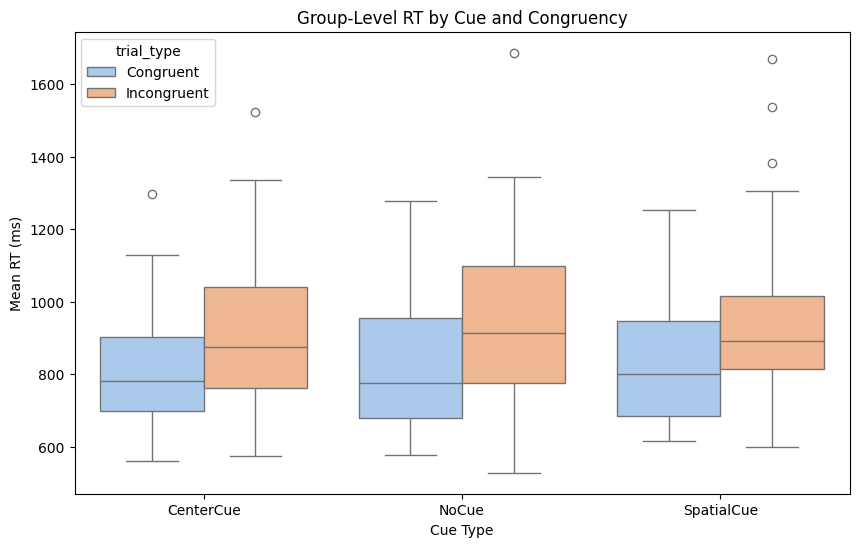

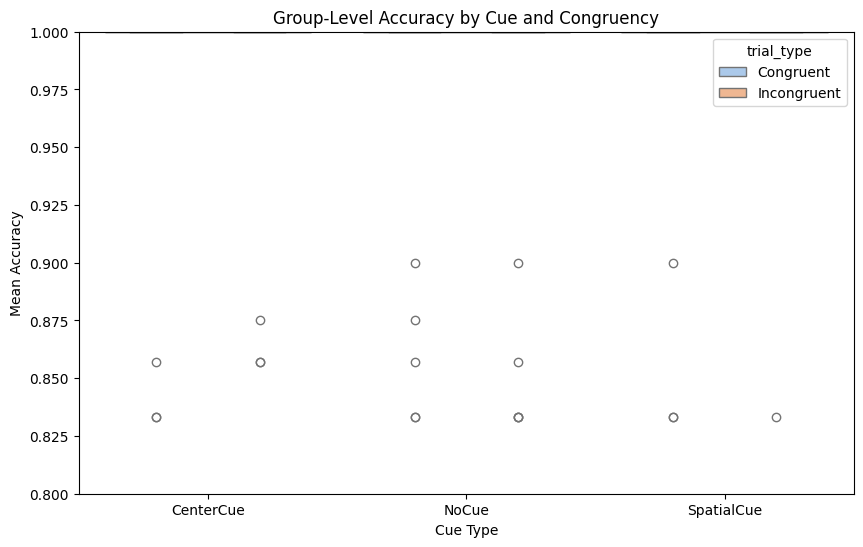

In [24]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data=group_summary,
    x="prev_trial_type", y="mean_rt",
    hue="trial_type", palette="pastel"
)
plt.title("Group-Level RT by Cue and Congruency")
plt.xlabel("Cue Type")
plt.ylabel("Mean RT (ms)")
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(
    data=group_summary,
    x="prev_trial_type", y="acc_rate",
    hue="trial_type", palette="pastel"
)
plt.title("Group-Level Accuracy by Cue and Congruency")
plt.xlabel("Cue Type")
plt.ylabel("Mean Accuracy")
plt.ylim(0.8, 1.0)
plt.show()

### Finally, let us compute the ANT network scores


Mean Network Effects (ms):
congruency_effect    140.5
alerting_effect        1.8
orienting_effect     -11.2
dtype: float64


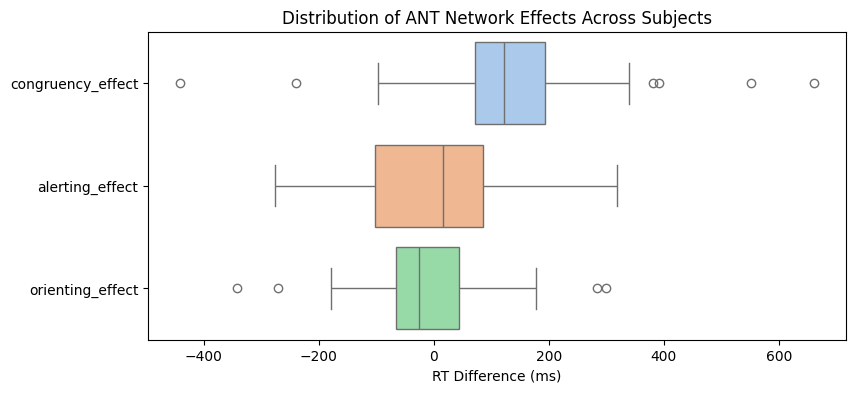

In [26]:
# Compute mean RT per subject × cue × congruency
pivot = (
    group_summary.pivot_table(
        index="subject",
        columns=["prev_trial_type", "trial_type"],
        values="mean_rt"
    )
)

# Compute network effects (using available data)
network_effects = pd.DataFrame({
    "congruency_effect": pivot["NoCue"]["Incongruent"] - pivot["NoCue"]["Congruent"],
    "alerting_effect": pivot["NoCue"]["Congruent"] - pivot["CenterCue"]["Congruent"],
    "orienting_effect": pivot["CenterCue"]["Congruent"] - pivot["SpatialCue"]["Congruent"],
})

print("\nMean Network Effects (ms):")
print(network_effects.mean().round(1))

# Plot distributions

plt.figure(figsize=(9,4))
sns.boxplot(data=network_effects, orient="h", palette="pastel")
plt.title("Distribution of ANT Network Effects Across Subjects")
plt.xlabel("RT Difference (ms)")
plt.show()


Recomputed Network Effects (ms):
congruency_effect    87.7
alerting_effect      -2.8
orienting_effect     -2.2
dtype: float64


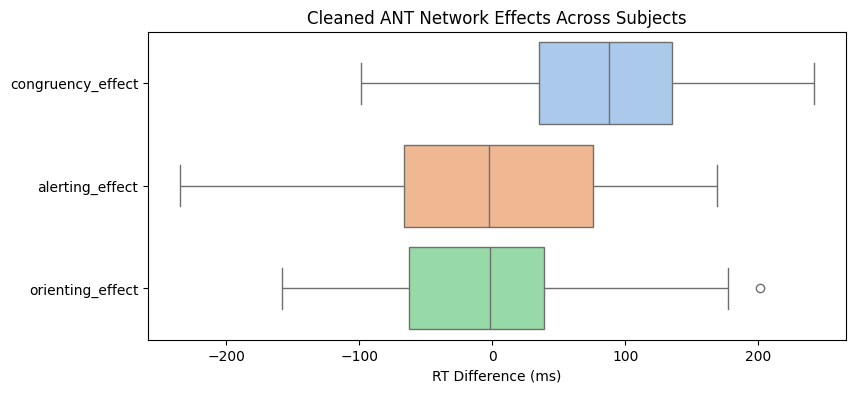

In [28]:
rt_col = "mean_rt" if "mean_rt" in group_df.columns else "response_time"

# --- Step 1: Keep only valid RTs ---
clean_df = group_df[group_df[rt_col].between(200, 1200)].copy()

# --- Step 2: Check completeness per subject ---
valid_subs = (
    clean_df
    .query("trial_type == 'Congruent'")
    .groupby("subject")["prev_trial_type"]
    .nunique()
)
valid_subs = valid_subs[valid_subs == 3].index  # only subjects with all 3 cue types

clean_df = clean_df[clean_df["subject"].isin(valid_subs)]

# --- Step 3: Recompute pivot and network effects ---
pivot = (
    clean_df.pivot_table(
        index="subject",
        columns=["prev_trial_type", "trial_type"],
        values=rt_col
    )
)

network_effects = pd.DataFrame({
    "congruency_effect": pivot["NoCue"]["Incongruent"] - pivot["NoCue"]["Congruent"],
    "alerting_effect": pivot["NoCue"]["Congruent"] - pivot["CenterCue"]["Congruent"],
    "orienting_effect": pivot["CenterCue"]["Congruent"] - pivot["SpatialCue"]["Congruent"],
}).dropna()

print("\nRecomputed Network Effects (ms):")
print(network_effects.mean().round(1))

# --- Step 4: Visualize again ---
plt.figure(figsize=(9,4))
sns.boxplot(data=network_effects, orient="h", palette="pastel")
plt.title("Cleaned ANT Network Effects Across Subjects")
plt.xlabel("RT Difference (ms)")
plt.show()


In [29]:
base_path = "../data/ds001907"
cue_types = ['SpatialCue', 'CenterCue', 'NoCue']
target_types = ['Congruent', 'Incongruent']

def load_all_subjects_refined(base_path):
    all_subjects = []
    subs = sorted([s for s in os.listdir(base_path) if s.startswith("sub-")])
    
    for sub in tqdm(subs):
        sub_events = []
        for ses in ["ses-1", "ses-2"]:
            ses_path = os.path.join(base_path, sub, ses, "func")
            if not os.path.exists(ses_path):
                continue
            for file in os.listdir(ses_path):
                if file.endswith("_events.tsv"):
                    run = file.split("_run-")[1].split("_")[0] if "_run-" in file else "1"
                    df = pd.read_csv(os.path.join(ses_path, file), sep="\t")
                    df["subject"], df["session"], df["run"] = sub, ses, run
                    
                    # Pair each target with the nearest preceding cue (<3 s apart)
                    cues = df[df["trial_type"].isin(cue_types)][["onset","trial_type"]]
                    targets = df[df["trial_type"].isin(target_types)].copy()
                    targets["prev_trial_type"] = None
                    for i, trow in targets.iterrows():
                        valid_cues = cues[cues["onset"] < trow["onset"]]
                        if not valid_cues.empty:
                            cue = valid_cues.iloc[-1]
                            if trow["onset"] - cue["onset"] < 3.0:
                                targets.at[i,"prev_trial_type"] = cue["trial_type"]
                    sub_events.append(targets.dropna(subset=["prev_trial_type"]))
        if sub_events:
            all_subjects.append(pd.concat(sub_events, ignore_index=True))
    return pd.concat(all_subjects, ignore_index=True)

group_df = load_all_subjects_refined(base_path)


100%|██████████| 46/46 [00:16<00:00,  2.81it/s]



Recomputed Network Effects (ms):
congruency_effect    87.1
alerting_effect      33.4
orienting_effect     55.2
dtype: float64


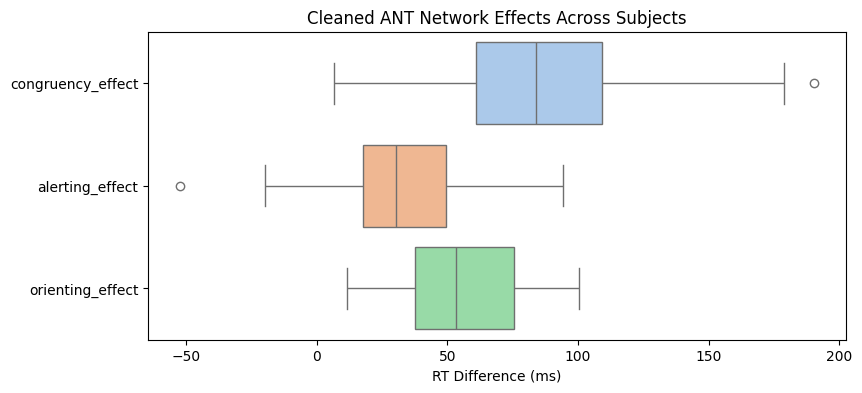

In [30]:
rt_col = "mean_rt" if "mean_rt" in group_df.columns else "response_time"

# --- Step 1: Keep only valid RTs ---
clean_df = group_df[group_df[rt_col].between(200, 1200)].copy()

# --- Step 2: Check completeness per subject ---
valid_subs = (
    clean_df
    .query("trial_type == 'Congruent'")
    .groupby("subject")["prev_trial_type"]
    .nunique()
)
valid_subs = valid_subs[valid_subs == 3].index  # only subjects with all 3 cue types

clean_df = clean_df[clean_df["subject"].isin(valid_subs)]

# --- Step 3: Recompute pivot and network effects ---
pivot = (
    clean_df.pivot_table(
        index="subject",
        columns=["prev_trial_type", "trial_type"],
        values=rt_col
    )
)

network_effects = pd.DataFrame({
    "congruency_effect": pivot["NoCue"]["Incongruent"] - pivot["NoCue"]["Congruent"],
    "alerting_effect": pivot["NoCue"]["Congruent"] - pivot["CenterCue"]["Congruent"],
    "orienting_effect": pivot["CenterCue"]["Congruent"] - pivot["SpatialCue"]["Congruent"],
}).dropna()

print("\nRecomputed Network Effects (ms):")
print(network_effects.mean().round(1))

# --- Step 4: Visualize again ---
plt.figure(figsize=(9,4))
sns.boxplot(data=network_effects, orient="h", palette="pastel")
plt.title("Cleaned ANT Network Effects Across Subjects")
plt.xlabel("RT Difference (ms)")
plt.show()


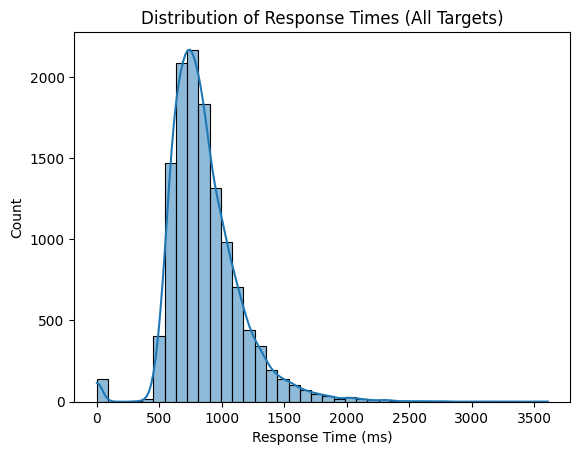

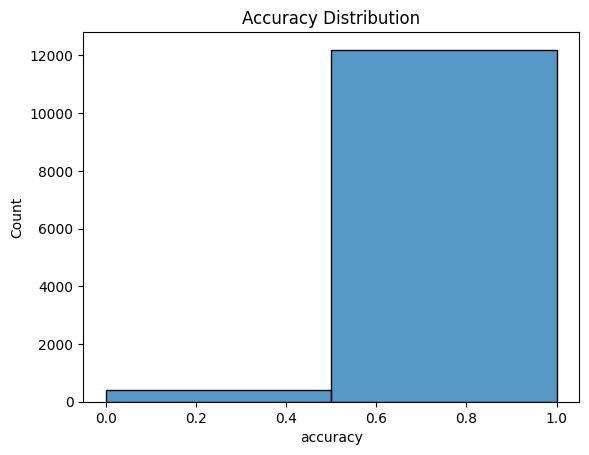

In [31]:
sns.histplot(group_df["response_time"], bins=40, kde=True)
plt.title("Distribution of Response Times (All Targets)")
plt.xlabel("Response Time (ms)")
plt.show()

sns.histplot(group_df["accuracy"], bins=2)
plt.title("Accuracy Distribution")
plt.show()

In [32]:
pd.crosstab(group_df["prev_trial_type"], group_df["trial_type"])

trial_type,Congruent,Incongruent
prev_trial_type,,
CenterCue,2206,2205
NoCue,2205,2205
SpatialCue,2207,2208


In [34]:
subject_summary = (
    group_df.groupby("subject")
    .agg(n_trials=("response_time","count"), acc_mean=("accuracy","mean"))
)
display(subject_summary.describe())

,n_trials,acc_mean
count,46.000000,44.000000
mean,273.913043,0.968008
std,59.561295,0.047174
min,0.000000,0.729167
25%,288.000000,0.964410
50%,288.000000,0.986111
75%,288.000000,0.993056
max,288.000000,1.000000


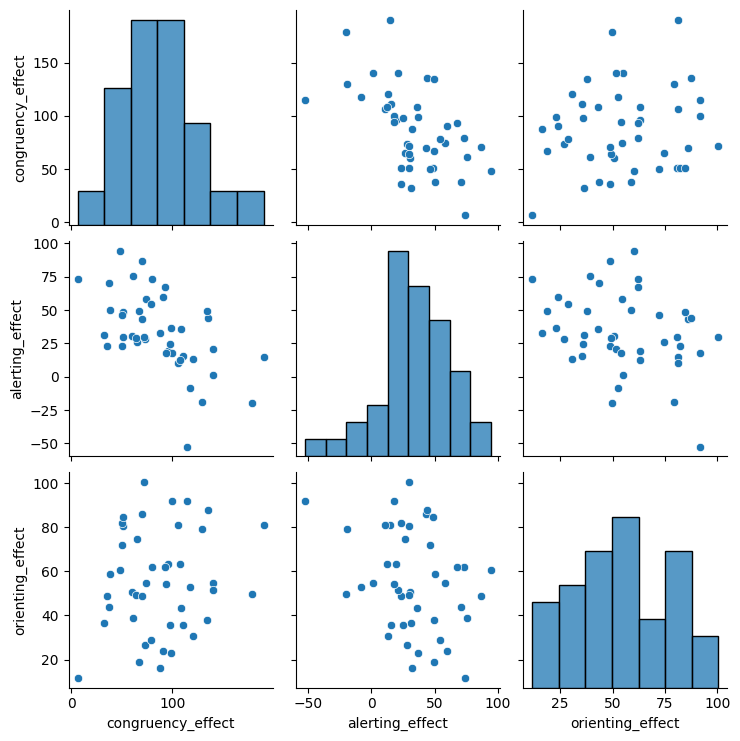

In [35]:
sns.pairplot(network_effects)